In [13]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

%load_ext autoreload
%autoreload 2

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
#df_rki = cov19.data_retrieval.get_rki()
import pickle
#pickle.dump(df_rki, open('df_rki.pickled', 'wb'))
df_rki = pickle.load(open('df_rki.pickled', 'rb'))

In [37]:
df_bundeslaender = cov19.filter_rki_all_bundesland(df_rki, '2020-03-10', '2020-04-13')
new_cases_obs = np.diff(np.array(df_bundeslaender),axis=0)[:,:]


date_begin_data = datetime.datetime(2020,3,10)
date_end_data   = datetime.datetime(2020,3,13)
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_forecast = 10

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

change_points = [dict(pr_mean_date_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 1)]

In [55]:
params_model = dict(new_cases_obs = new_cases_obs[:,:],
                    date_begin_data = date_begin_data,
                    num_days_forecast = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 83e6) 
# normally one would put as N_population an array with the number of inhabitants of 
# of each state

with cov19.Cov19_Model(**params_model) as model:
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4,
                                                change_points_list = change_points)
    
    new_I_t = cov19.SIR(lambda_t_log, pr_median_mu=1/8)
    
    new_cases_inferred_raw = cov19.delay_cases(new_I_t, pr_median_delay=10, 
                                               pr_median_scale_delay=0.3)
    
    #new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    cov19.student_t_likelihood(new_cases_inferred_raw)


In [ ]:
trace = pm.sample(model=model, tune=500, draws=500, chains=6, cores=6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/jdehning/.theano/compiledir_Linux-4.18--generic-x86_64-with-debian-buster-sid-x86_64-3.7.6-64/lock_dir/lock
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [sigma_obs, delay_L2_raw, delay_L1, sigma_delay_L2, I_begin, mu, transient_len_3_L2_raw, transient_len_3_L1, sigma_transient_len_3_L2, transient_len_2_L2_raw, transient_len_2_L1, sigma_transient_len_2_L2, transient_len_1_L2_raw, transient_len_1_L1, sigma_transient_len_1_L2, transient_day_3_L2_raw, transient_day_3_L1, sigma_transient_day_3_L2, transient_day_2_L2_raw, transient_day_2_L1, sigma_transient_day_2_L2, transient_day_1_L2_raw, transient_day_1_L1, sigma_transient_day_1_L2, lambda_3_L2_raw, lambda_3_L1, sigma_lambda_3_L2, lambda_2_L2_raw, lambda_2_L1, sigma_lambda_2_L2, lambda_1_L2_raw, lambda_1_L1, sigma_lambda_1_L2, lambda_0_L2_raw, lambda_0_L1, sigma_lambda_0_L2]
Sampling 6 chains, 0 divergences:

{'mu': mu, 'rho': rho}
[sigma_transient_day_1_L2_log__, transient_len_3_L1, transient_len_2_L2_raw, sigma_transient_len_3_L2_log__, transient_len_3_L2_raw, I_begin_log__, transient_day_3_L2_raw, transient_day_1_L2_raw, transient_len_1_L2_raw, sigma_delay_L2_log__, lambda_0_L1, sigma_lambda_1_L2_log__, sigma_lambda_2_L2_log__, transient_day_2_L1, transient_day_3_L1, sigma_lambda_3_L2_log__, lambda_3_L1, transient_len_1_L1, transient_len_2_L1, sigma_transient_len_2_L2_log__, transient_day_2_L2_raw, sigma_transient_day_3_L2_log__, sigma_lambda_0_L2_log__, lambda_2_L1, lambda_2_L2_raw, sigma_obs_log__, lambda_3_L2_raw, lambda_0_L2_raw, lambda_1_L2_raw, sigma_transient_day_2_L2_log__, mu_log__, delay_L1, delay_L2_raw, sigma_transient_len_1_L2_log__, lambda_1_L1, transient_day_1_L1]
[ 2.48490665  1.38629436  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.69314718  0. 

INFO (theano.gof.compilelock): Refreshing lock /home/jdehning/.theano/compiledir_Linux-4.18--generic-x86_64-with-debian-buster-sid-x86_64-3.7.6-64/lock_dir/lock
Average Loss = 3,563.9:  34%|███▍      | 6846/20000 [04:35<08:49, 24.82it/s]
Interrupted at 6,846 [34%]: Average Loss = 4,185.2


{'sigma_transient_day_1_L2_log__': array(1.89990374), 'transient_len_3_L1': array(1.36301284), 'transient_len_2_L2_raw': array([-0.00605726, -0.03598498,  0.09443002,  0.04584744,  0.08387427,
        0.09452097,  0.05523165,  0.08554469,  0.07053146,  0.00551466,
        0.07876226,  0.07039858,  0.04337908,  0.05562855,  0.06753056,
        0.05555893]), 'sigma_transient_len_3_L2_log__': array(0.20772789), 'transient_len_3_L2_raw': array([-0.05538018, -0.07552975,  0.01945282,  0.03344293,  0.08160667,
        0.03445071, -0.02583659,  0.08558298,  0.02224937, -0.00676857,
        0.02115252,  0.02410105,  0.04052225,  0.07616767,  0.04055618,
        0.02722205]), 'I_begin_log__': array([5.36373146, 5.59759793, 4.12170156, 3.63399613, 3.47476418,
       4.03358092, 4.31390889, 3.52297331, 4.48148742, 5.40656678,
       4.14616914, 3.68933095, 3.98442514, 3.51743296, 3.71198488,
       3.55950029]), 'transient_day_3_L2_raw': array([ 0.03557923,  0.05172024, -0.00337688,  0.03395121, 

AttributeError: 'ADVI' object has no attribute 'sample'

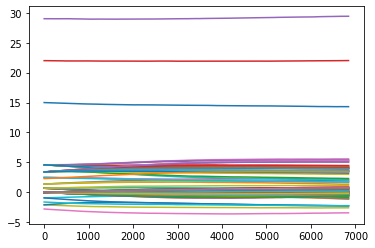

In [52]:
from theano.compile.nanguardmode import NanGuardMode
from theano.compile.mode  import FAST_COMPILE

mode = NanGuardMode(nan_is_error=True, inf_is_error=False, big_is_error=False,
                    optimizer='o1')


with model:
    #vi = pm.fit(method='advi')
    advi = pm.ADVI()
    #advi = pm.ADVI()
    print(advi.approx.shared_params)
    print(advi.approx.group)

    print(advi.approx.mean.eval())
    print(advi.approx.std.eval())
    
    tracker = pm.callbacks.Tracker(
        mean=advi.approx.mean.eval,  # callable that returns mean
        std=advi.approx.std.eval  # callable that returns std
    )
    #approx = pm.fit(n=10000, method='advi', model=model,
    #        obj_optimizer=pm.adagrad_window(learning_rate=2e-4)
    #        )
    approx = advi.fit(20000, callbacks=[tracker], fn_kwargs={'mode':mode},
                      obj_optimizer=pm.adagrad_window(learning_rate=2e-3))
                      #total_grad_norm_constraint=10)
    print(approx.groups[0].bij.rmap(approx.params[0].eval()))

    plt.plot(tracker['mean'])

    trace = advi.sample(1000)

INFO (theano.gof.compilelock): Refreshing lock /home/jdehning/.theano/compiledir_Linux-4.18--generic-x86_64-with-debian-buster-sid-x86_64-3.7.6-64/lock_dir/lock


Dimension of lambda_0_L2_raw larger than one, skipping
Dimension of I_begin larger than one, skipping
Dimension of delay_L2_raw larger than one, skipping
Dimension of sigma_weekend_factor_L2 larger than one, skipping


TypeError: Expected Variable, got [-1.00946068 -0.98789006 -0.96631945 -0.94474883 -0.92317821 -0.90160759
 -0.88003698 -0.85846636 -0.83689574 -0.81532513 -0.79375451 -0.77218389
 -0.75061327 -0.72904266 -0.70747204 -0.68590142 -0.66433081 -0.64276019
 -0.62118957 -0.59961895 -0.57804834 -0.55647772 -0.5349071  -0.51333649
 -0.49176587 -0.47019525 -0.44862464 -0.42705402 -0.4054834  -0.38391278
 -0.36234217 -0.34077155 -0.31920093 -0.29763032 -0.2760597  -0.25448908
 -0.23291846 -0.21134785 -0.18977723 -0.16820661 -0.146636   -0.12506538
 -0.10349476 -0.08192414 -0.06035353 -0.03878291 -0.01721229  0.00435832
  0.02592894  0.04749956  0.06907018  0.09064079  0.11221141  0.13378203
  0.15535264  0.17692326  0.19849388  0.2200645   0.24163511  0.26320573
  0.28477635  0.30634696  0.32791758  0.3494882   0.37105881  0.39262943
  0.41420005  0.43577067  0.45734128  0.4789119   0.50048252  0.52205313
  0.54362375  0.56519437  0.58676499  0.6083356   0.62990622  0.65147684
  0.67304745  0.69461807  0.71618869  0.73775931  0.75932992  0.78090054
  0.80247116  0.82404177  0.84561239  0.86718301  0.88875363  0.91032424
  0.93189486  0.95346548  0.97503609  0.99660671  1.01817733  1.03974795
  1.06131856  1.08288918  1.1044598   1.12603041] of type <class 'numpy.ndarray'>

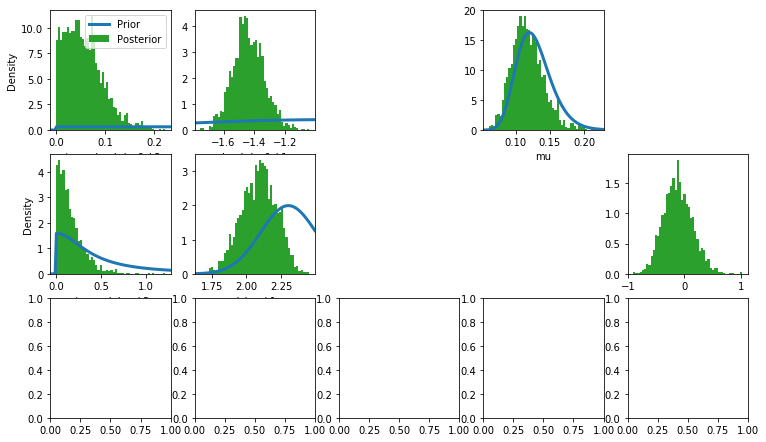

In [34]:
varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)


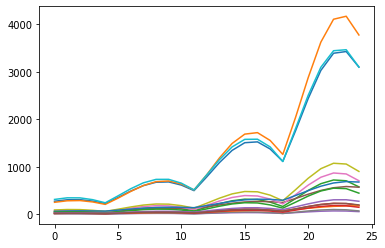

In [35]:
plt.plot(np.median(trace.new_cases, axis=0))